In [1]:
import pandas as pd
import numpy as np

## Import data and make first transformations

In [2]:
train_path = '/Users/user/Desktop/all/train.csv'
test_path = '/Users/user/Desktop/all/test.csv'
macro_path = '/Users/user/Desktop/all/macro.csv'


train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
macro_data = pd.read_csv(macro_path)

train_data.shape, test_data.shape

((30471, 292), (7662, 291))

In [164]:
def get_subs(train_data, test_data):
    # merge 
    total_data = pd.concat([train_data, test_data], axis = 0)
    areas = pd.get_dummies(pd.Series(total_data['sub_area']))
    total_data = pd.concat([total_data, areas], axis=1)

    # split back
    train_subs = total_data.iloc[0:len(train_data), -146:]
    test_subs = total_data.iloc[len(train_data):, -146:]
    
    # change train and test
    short_train = pd.concat([train_data.iloc[:, 1:13], train_data['price_doc'], train_subs], axis=1)
    short_train = short_train.drop(['sub_area'], axis=1)

    short_test = pd.concat([test_data.iloc[:, 1:13], test_subs], axis=1)
    short_test = short_test.drop(['sub_area'], axis=1)

    return short_train, short_test

type_col = pd.Series(pd.concat([train_data, test_data], axis = 0, sort=False)['product_type'])

def scale_time(X):
    X['timestamp'] = pd.DatetimeIndex(X['timestamp']).astype(np.int64) // 1000000
    time_unscaled = X['timestamp']
    min_time = 1369094400000.0
    max_time = 1435622400000.0
    X['timestamp'] = 100*(time_unscaled - min_time) // (max_time - min_time)
    return X

def categorize_type(X):
    typezz = pd.DataFrame(type_col.unique()).to_dict()[0]
    typez = dict (zip(typezz.values(), typezz.keys()))
    X['product_type'].replace(to_replace=typez, inplace=True)
    return X

In [4]:
train, test = get_subs(train_data, test_data)

train = categorize_type(scale_time(train))
test = categorize_type(scale_time(test))

/Users/user/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
train.shape, test.shape

((30471, 158), (7662, 157))

In [6]:
{x: sum(train[x].isnull()) for x in train.columns}

{'timestamp': 0,
 'full_sq': 0,
 'life_sq': 6383,
 'floor': 167,
 'max_floor': 9572,
 'material': 9572,
 'build_year': 13605,
 'num_room': 9572,
 'kitch_sq': 9572,
 'state': 13559,
 'product_type': 0,
 'price_doc': 0,
 'Ajeroport': 0,
 'Akademicheskoe': 0,
 'Alekseevskoe': 0,
 "Altuf'evskoe": 0,
 'Arbat': 0,
 'Babushkinskoe': 0,
 'Basmannoe': 0,
 'Begovoe': 0,
 'Beskudnikovskoe': 0,
 'Bibirevo': 0,
 'Birjulevo Vostochnoe': 0,
 'Birjulevo Zapadnoe': 0,
 'Bogorodskoe': 0,
 'Brateevo': 0,
 'Butyrskoe': 0,
 'Caricyno': 0,
 'Cheremushki': 0,
 "Chertanovo Central'noe": 0,
 'Chertanovo Juzhnoe': 0,
 'Chertanovo Severnoe': 0,
 'Danilovskoe': 0,
 'Dmitrovskoe': 0,
 'Donskoe': 0,
 'Dorogomilovo': 0,
 'Filevskij Park': 0,
 'Fili Davydkovo': 0,
 'Gagarinskoe': 0,
 "Gol'janovo": 0,
 'Golovinskoe': 0,
 'Hamovniki': 0,
 'Horoshevo-Mnevniki': 0,
 'Horoshevskoe': 0,
 'Hovrino': 0,
 'Ivanovskoe': 0,
 'Izmajlovo': 0,
 'Jakimanka': 0,
 'Jaroslavskoe': 0,
 'Jasenevo': 0,
 'Juzhnoe Butovo': 0,
 'Juzhnoe Med

## Define transformers

In [165]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

In [166]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [144]:
from sklearn import linear_model

class LinReg(linear_model.LinearRegression, BaseEstimator, TransformerMixin):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    
    def transform(self, X, y=None):
        t = self.predict(X)
        return t[:, np.newaxis] #.reshape((1,-1))

In [130]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [162]:
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k=157)

## Stack models in a Pipeline

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


union = FeatureUnion([('selection', selection),
                    ('linear_model', LinReg())])

estimators = [('clearing', imp),
              ('union', union),
              ('xgboost', xgb_model)]

pipeline = Pipeline(estimators)

In [140]:
target = train['price_doc']
dataset  = train.drop(['price_doc'], axis=1)

In [141]:
pipeline.fit(dataset, target)

/Users/user/miniconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('clearing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('selection', SelectKBest(k=157, score_func=<function f_classif at 0x11b8f8400>)), ('linear_model', LinReg(copy_X=True, fit_intercept=True, n_j...     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75))])

In [142]:
a = pipeline.predict(test)

In [147]:
tr = pipeline.predict(train.drop(['price_doc'], axis=1))

In [148]:
from sklearn import metrics

metrics.mean_squared_log_error(tr, train['price_doc'])
# 0.203579400529207

0.203579400529207

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict


predicted = cross_val_predict(estimator=pipeline, X=dataset, y=target, cv=10)

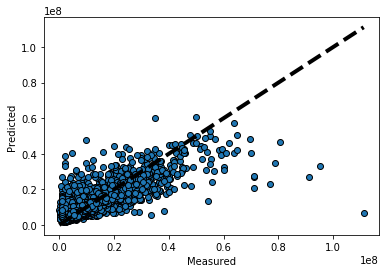

In [153]:
fig, ax = plt.subplots()
ax.scatter(target, predicted, edgecolors=(0, 0, 0))
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [152]:
metrics.mean_squared_log_error(predicted, train['price_doc'])
# 0.227713959661354

0.227713959661354

## Cross validation and Grid search

In [170]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'clearing', 'union', 'xgboost', 'clearing__axis', 'clearing__copy', 'clearing__missing_values', 'clearing__strategy', 'clearing__verbose', 'union__n_jobs', 'union__transformer_list', 'union__transformer_weights', 'union__selection', 'union__linear_model', 'union__selection__k', 'union__selection__score_func', 'union__linear_model__copy_X', 'union__linear_model__fit_intercept', 'union__linear_model__n_jobs', 'union__linear_model__normalize', 'xgboost__base_score', 'xgboost__booster', 'xgboost__colsample_bylevel', 'xgboost__colsample_bytree', 'xgboost__gamma', 'xgboost__learning_rate', 'xgboost__max_delta_step', 'xgboost__max_depth', 'xgboost__min_child_weight', 'xgboost__missing', 'xgboost__n_estimators', 'xgboost__n_jobs', 'xgboost__nthread', 'xgboost__objective', 'xgboost__random_state', 'xgboost__reg_alpha', 'xgboost__reg_lambda', 'xgboost__scale_pos_weight', 'xgboost__seed', 'xgboost__silent', 'xgboost__subsample'])

In [172]:
a3 = grid_search.predict(test)

## Adjust for submitting to Kaggle

In [173]:
preds = pd.DataFrame(a3)
result = pd.read_csv('/Users/user/Desktop/all/sample_submission.csv')
result['price_doc'] = preds

result.to_csv('submission3.csv', index=False)

In [175]:
metrics.mean_squared_log_error(grid_search.predict(train.drop(['price_doc'],axis=1)), train['price_doc'])

0.2109431742966435